In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import meshgrid
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from math import sqrt
from scipy.sparse import diags
from scipy.linalg import cholesky

## Create MATRIX data

In [17]:
Nx, Nt, sigma = 100, 50, 1.0
coefficients1 = [-2,3] #[-8,2]
coefficients2 = [3,1] #[7,1]
center_of_matrix1 = 80
center_of_matrix2 = 50 #200
seed = 3

In [18]:
np.random.seed(seed)

In [19]:
def generate_data(Nx, Nt, coeff1,coeff2, center1, center2, sigma_slope=0.1, sigma_base=3.0):
    sigma = 5.0
    x = np.arange(0, Nx)
    t = np.linspace(-10,10, Nt)
    [X, T] = np.meshgrid(x, t)
    X = X.T
    T = T.T    

    def gaussian(x, mu, sigma=1.0):
        return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

    q1 = np.zeros_like(X, dtype=np.float64)
    q2 = np.zeros_like(X, dtype=np.float64)
    shift1 = np.polyval(coeff1, t)
    shift2 = np.polyval(coeff2, t)
    for col in range(Nt):
        sigma_t = sigma_base #+ sigma_slope * t[col]
        #sigma_t = max(sigma_t, 1e-8)
        for row in range(Nx):
            q1[row, col] = gaussian(row, center1 + shift1[col], sigma_t)
            q2[row, col] = gaussian(row, center2 + shift2[col], sigma_t)
    
    Q = np.maximum(q1, q2)
    Q /= Q.max()
    
    return Q, x, t

In [20]:
Q,x,t = generate_data(Nx, Nt, coefficients1, coefficients2, center_of_matrix2,center_of_matrix2)

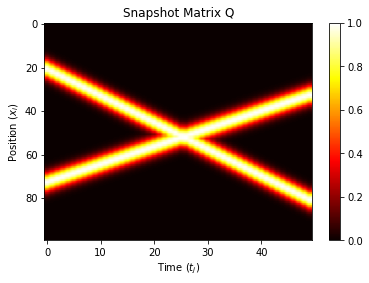

In [21]:
plt.imshow(Q, cmap='hot', aspect='auto')
plt.colorbar()
plt.xlabel('Time ($t_j$)')
plt.ylabel('Position ($x_i$)')
plt.title('Snapshot Matrix Q')
plt.show()

## Define inputs

In [22]:
np.random.seed(seed)
torch.manual_seed(seed)

In [23]:
inputs = np.stack([x.repeat(Nt), np.tile(t, Nx)], axis=1)
targets = Q.flatten()
indices = np.indices((Q.shape[0], Q.shape[1])).transpose(1, 2, 0).reshape(-1, 2)

inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)
indices_tensor = torch.tensor(indices, dtype=torch.int32)

dataset = TensorDataset(inputs_tensor, targets_tensor, indices_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)


# Define a model

In [35]:
class NuclearNormAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_matrix):
        ctx.save_for_backward(input_matrix)
        return torch.linalg.matrix_norm(input_matrix, ord="nuc")

    @staticmethod
    def backward(ctx, grad_output):
        input_matrix, = ctx.saved_tensors
        u, s, v = torch.svd(input_matrix, some=False)
        rank = torch.sum(s > 0).item()
        dtype = input_matrix.dtype
        eye_approx = torch.diag((s > 0).to(dtype)[:rank])
        grad_input = torch.matmul(torch.matmul(u[:, :rank], eye_approx), v[:, :rank].t())
        return grad_input * grad_output.unsqueeze(-1).unsqueeze(-1)

In [40]:
class ShapeShiftNet(nn.Module):
    def __init__(self, p_init_coeffs1, p_init_coeffs2):
        super(ShapeShiftNet, self).__init__()
        
        self.alphas1 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs1[::-1]]
        )
        self.alphas2 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs2[::-1]]
        )
        self.elu = nn.ELU()
        
        # Subnetwork for f^1 and shift^1
        self.f1_fc1 = nn.Linear(2, 64)
        self.f1_fc2 = nn.Linear(64, 64)
        self.f1_fc3 = nn.Linear(64, 64)
        self.f1_fc4 = nn.Linear(64, 1)
        
        self.shift1_fc1 = nn.Linear(1, 32)
        self.shift1_fc2 = nn.Linear(32, 32)
        self.shift1_fc3 = nn.Linear(32, 1)

        # Subnetwork for f^2 and shift^2
        self.f2_fc1 = nn.Linear(2, 64)
        self.f2_fc2 = nn.Linear(64, 64)
        self.f2_fc3 = nn.Linear(64, 64)
        self.f2_fc4 = nn.Linear(64, 1)
        
        self.shift2_fc1 = nn.Linear(1, 32)
        self.shift2_fc2 = nn.Linear(32, 32)
        self.shift2_fc3 = nn.Linear(32, 1)
        
    def forward(self, x, t):
        # Pathway for f^1 and shift^1
        shift1 = sum([coeff * t**i for i, coeff in enumerate(self.alphas1)])
        #shift1 = self.elu(self.shift1_fc1(t))
        #shift1 = self.elu(self.shift1_fc2(shift1))
        #shift1 = self.shift1_fc3(shift1)
        x_shifted1 = x + shift1
        f1 = self.elu(self.f1_fc1(torch.cat((x_shifted1, t), dim=1)))
        f1 = self.elu(self.f1_fc2(f1))
        f1 = self.elu(self.f1_fc3(f1))
        f1 = self.f1_fc4(f1)
        
        f1_without_shift = self.elu(self.f1_fc1(torch.cat((x, t), dim=1)))
        f1_without_shift = self.elu(self.f1_fc2(f1_without_shift))
        f1_without_shift = self.elu(self.f1_fc3(f1_without_shift))
        f1_without_shift = self.f1_fc4(f1_without_shift)
        
        
        # Pathway for f^2 and shift^2
        shift2 = sum([coeff * t**i for i, coeff in enumerate(self.alphas2)])
        #shift2 = self.elu(self.shift2_fc1(t))
        #shift2 = self.elu(self.shift2_fc2(shift2))
        #shift2 = self.shift2_fc3(shift2)
        x_shifted2 = x + shift2
        f2 = self.elu(self.f2_fc1(torch.cat((x_shifted2, t), dim=1)))
        f2 = self.elu(self.f2_fc2(f2))
        f2 = self.elu(self.f2_fc3(f2))
        f2 = self.f2_fc4(f2)
        
        f2_without_shift = self.elu(self.f2_fc1(torch.cat((x, t), dim=1)))
        f2_without_shift = self.elu(self.f2_fc2(f2_without_shift))
        f2_without_shift = self.elu(self.f2_fc3(f2_without_shift))
        f2_without_shift = self.f2_fc4(f2_without_shift)
        
        return f1, f2, shift1, shift2, f1_without_shift, f2_without_shift


In [41]:
init_coefficients1 = [-1,1]
init_coefficients2 = [1,1]

In [42]:
model = ShapeShiftNet(init_coefficients1, init_coefficients2)

torch.manual_seed(seed)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
num_epochs = 500
lambda_k = 1

for epoch in range(num_epochs + 1):
    for batch_inputs, batch_targets, batch_indices in data_loader:
        x, t = batch_inputs[:, 0:1], batch_inputs[:, 1:2]
        optimizer.zero_grad()
        f1_pred, f2_pred, _, _, f1_pred_nos, f2_pred_nos = model(x, t)
        
        loss = torch.norm(batch_targets - f1_pred - f2_pred, 'fro')**2
                
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

Epoch 0/500, Loss: 0.16990621387958527



KeyboardInterrupt



In [46]:
num_epochs = 500
lambda_k = 1
Q_tensor = torch.tensor(Q)

for epoch in range(num_epochs + 1):
    f1_pred_nos_accumulated = torch.zeros_like(Q_tensor)
    f2_pred_nos_accumulated = torch.zeros_like(Q_tensor)
    accumulated_loss = 0.0
    
    for batch_inputs, batch_targets, batch_indices in data_loader:
        x, t = batch_inputs[:, 0:1], batch_inputs[:, 1:2]
        optimizer.zero_grad()
        f1_pred, f2_pred, _, _, f1_pred_nos, f2_pred_nos = model(x, t)
        for i, batch_idx in enumerate(batch_indices):
            f1_pred_nos_accumulated[batch_idx[0],batch_idx[1]] = f1_pred_nos[i]
            f2_pred_nos_accumulated[batch_idx[0],batch_idx[1]] = f2_pred_nos[i]
        
        loss = torch.norm(batch_targets - f1_pred - f2_pred, 'fro')**2
        accumulated_loss += loss
        loss.backward(retain_graph=True)
        #optimizer.step()
                
    optimizer.zero_grad()
        
    nuclear_norm_f1 = NuclearNormAutograd.apply(f1_pred_nos_accumulated)
    nuclear_norm_f2 = NuclearNormAutograd.apply(f2_pred_nos_accumulated)
    nuclear_loss = lambda_k*(nuclear_norm_f1 + nuclear_norm_f2)
    
    total_loss = accumulated_loss/len(data_loader) + nuclear_loss
    
    total_loss.backward()
    optimizer.step()
    
    f1_pred_nos_accumulated.zero_()
    f2_pred_nos_accumulated.zero_()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Frobenius Loss: {loss.item()}, Nuclear loss: {nuclear_loss.item()}, Total loss: {total_loss.item()}')

Epoch 0/500, Frobenius Loss: 0.6715461015701294, Nuclear loss: 91.61350924921547, Total loss: 95.81562144709144
Epoch 100/500, Frobenius Loss: 1.5878474712371826, Nuclear loss: 7.038646011761224, Total loss: 15.429929047039543
Epoch 200/500, Frobenius Loss: 2.108433961868286, Nuclear loss: 4.6712683717408, Total loss: 12.205263523260577
Epoch 300/500, Frobenius Loss: 0.02577368915081024, Nuclear loss: 3.975634012730436, Total loss: 11.331670675785857
Epoch 400/500, Frobenius Loss: 0.12186279147863388, Nuclear loss: 2.607255887673241, Total loss: 9.621462297127586
Epoch 500/500, Frobenius Loss: 0.8869726657867432, Nuclear loss: 4.42306849889772, Total loss: 11.080302213955093


In [47]:
with torch.no_grad():
    f1_output, f2_output, shift1_pred, shift2_pred, f1_output_nos, f2_output_nos = model(inputs_tensor[:, 0:1], inputs_tensor[:, 1:2])

combined = f1_output + f2_output
Q_tilde = combined.numpy().reshape(Nx, Nt)
f1_matrix = f1_output.view(Nx, Nt).detach().numpy()
f2_matrix = f2_output.view(Nx, Nt).detach().numpy()
f1_matrix_nos = f1_output_nos.view(Nx, Nt).detach().numpy()
f2_matrix_nos = f2_output_nos.view(Nx, Nt).detach().numpy()

Text(0, 0.5, 'Position ($x_i$)')

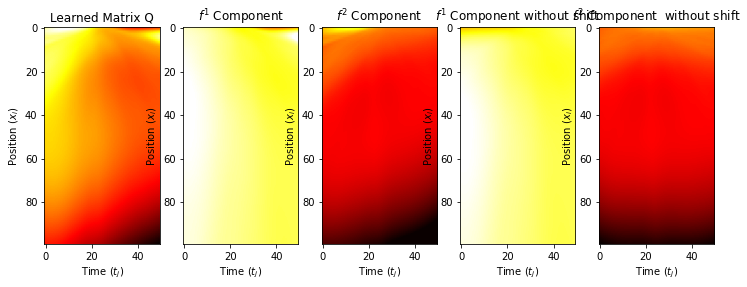

In [48]:
#lambda_k = 10
fig, axs = plt.subplots(1, 5, figsize=(12, 4))
vmin = np.min(Q_tilde)
vmax = np.max(Q_tilde)

#Qtilde
axs[0].imshow(Q_tilde, vmin=vmin, vmax=vmax, cmap='hot', aspect='auto')
axs[0].set_title('Learned Matrix Q')
axs[0].set_xlabel('Time ($t_j$)')
axs[0].set_ylabel('Position ($x_i$)')

# f^1
axs[1].imshow(f1_matrix, vmin=vmin, vmax=vmax,cmap='hot', aspect='auto')
axs[1].set_title('$f^1$ Component')
axs[1].set_xlabel('Time ($t_j$)')
axs[1].set_ylabel('Position ($x_i$)')

# f^2
axs[2].imshow(f2_matrix, vmin=vmin, vmax=vmax, cmap='hot', aspect='auto')
axs[2].set_title('$f^2$ Component')
axs[2].set_xlabel('Time ($t_j$)')
axs[2].set_ylabel('Position ($x_i$)')

# f^1
axs[3].imshow(f1_matrix_nos, vmin=vmin, vmax=vmax,cmap='hot', aspect='auto')
axs[3].set_title('$f^1$ Component without shift')
axs[3].set_xlabel('Time ($t_j$)')
axs[3].set_ylabel('Position ($x_i$)')

# f^2
axs[4].imshow(f2_matrix_nos, vmin=vmin, vmax=vmax,cmap='hot', aspect='auto')
axs[4].set_title('$f^2$ Component  without shift')
axs[4].set_xlabel('Time ($t_j$)')
axs[4].set_ylabel('Position ($x_i$)')

Text(0, 0.5, 'Position ($x_i$)')

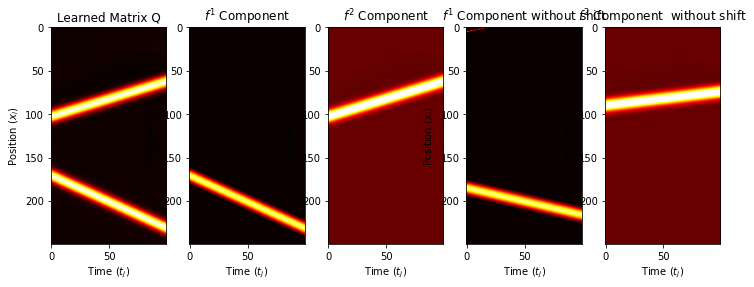

In [16]:
# lambda_k = 10
fig, axs = plt.subplots(1, 5, figsize=(12, 4))
vmin = np.min(Q_tilde)
vmax = np.max(Q_tilde)

#Qtilde
axs[0].imshow(Q_tilde, vmin=vmin, vmax=vmax, cmap='hot', aspect='auto')
axs[0].set_title('Learned Matrix Q')
axs[0].set_xlabel('Time ($t_j$)')
axs[0].set_ylabel('Position ($x_i$)')

# f^1
axs[1].imshow(f1_matrix, vmin=vmin, vmax=vmax,cmap='hot', aspect='auto')
axs[1].set_title('$f^1$ Component')
axs[1].set_xlabel('Time ($t_j$)')
axs[1].set_ylabel('Position ($x_i$)')

# f^2
axs[2].imshow(f2_matrix, vmin=vmin, vmax=vmax, cmap='hot', aspect='auto')
axs[2].set_title('$f^2$ Component')
axs[2].set_xlabel('Time ($t_j$)')
axs[2].set_ylabel('Position ($x_i$)')

# f^1
axs[3].imshow(f1_matrix_nos, vmin=vmin, vmax=vmax,cmap='hot', aspect='auto')
axs[3].set_title('$f^1$ Component without shift')
axs[3].set_xlabel('Time ($t_j$)')
axs[3].set_ylabel('Position ($x_i$)')

# f^2
axs[4].imshow(f2_matrix_nos, vmin=vmin, vmax=vmax,cmap='hot', aspect='auto')
axs[4].set_title('$f^2$ Component  without shift')
axs[4].set_xlabel('Time ($t_j$)')
axs[4].set_ylabel('Position ($x_i$)')

## Wildlandfire 2D

In [ ]:
def generate_wildlandfire_data(grid, time, snapshot, shifts):
    x = np.load(grid, allow_pickle=True)[0]
    t = np.load(time)
    L = x[-1]
    Nx = len(x)
    Nt = len(t)
    q = np.load(snapshot)
    Q = q[:Nx, :]  # Temperature
    # Q = q[Nx:, :]  # Supply mass
    shift_list = np.load(shifts)
    [X, T] = meshgrid(x, t)
    X = X.T
    T = T.T
    dx = x[1] - x[0]
    nmodes = [2, 2]

    return Q, shift_list, L, dx, Nx, Nt, nmodes, x, t

In [ ]:
prefix = "small_wildlandfire"

fields, shift_list, L, dx, Nx, Nt, nmodes, x, t = generate_wildlandfire_data(
    f"../{prefix}/1D_Grid.npy",
    f"../{prefix}/Time.npy",
    f"../{prefix}/SnapShotMatrix558.49.npy",
    f"../{prefix}/Shifts558.49.npy",
)

In [ ]:
qmat = np.reshape(fields, [Nx, Nt])

In [ ]:
inputs = np.stack([x.repeat(Nt), np.tile(t, Nx)], axis=1)
targets = qmat.flatten()

inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32).view(-1)

dataset = TensorDataset(inputs_tensor, targets_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
class ShapeShiftNet(nn.Module):
    def __init__(self):
        super(ShapeShiftNet, self).__init__()
        
        self.elu = nn.ELU()
        
        # Subnetwork for f^1 and shift^1
        self.f1_fc1 = nn.Linear(2, 64)
        self.f1_fc2 = nn.Linear(64, 64)
        self.f1_fc3 = nn.Linear(64, 64)
        self.f1_fc4 = nn.Linear(64, 1)
        
        self.shift1_fc1 = nn.Linear(1, 32)
        self.shift1_fc2 = nn.Linear(32, 32)
        self.shift1_fc3 = nn.Linear(32, 1)

        # Subnetwork for f^2 and shift^2
        self.f2_fc1 = nn.Linear(2, 64)
        self.f2_fc2 = nn.Linear(64, 64)
        self.f2_fc3 = nn.Linear(64, 64)
        self.f2_fc4 = nn.Linear(64, 1)
        
        self.shift2_fc1 = nn.Linear(1, 32)
        self.shift2_fc2 = nn.Linear(32, 32)
        self.shift2_fc3 = nn.Linear(32, 1)
        
    def forward(self, x, t):
        # Pathway for f^1 and shift^1
        shift1 = self.elu(self.shift1_fc1(t))
        shift1 = self.elu(self.shift1_fc2(shift1))
        shift1 = self.shift1_fc3(shift1)
        x_shifted1 = x + shift1
        f1 = self.elu(self.f1_fc1(torch.cat((x_shifted1, t), dim=1)))
        f1 = self.elu(self.f1_fc2(f1))
        f1 = self.elu(self.f1_fc3(f1))
        f1 = self.f1_fc4(f1)
        
        f1_without_shift = self.elu(self.f1_fc1(torch.cat((x, t), dim=1)))
        f1_without_shift = self.elu(self.f1_fc2(f1_without_shift))
        f1_without_shift = self.elu(self.f1_fc3(f1_without_shift))
        f1_without_shift = self.f1_fc4(f1_without_shift)
        
        
        # Pathway for f^2 and shift^2
        shift2 = self.elu(self.shift2_fc1(t))
        shift2 = self.elu(self.shift2_fc2(shift2))
        shift2 = self.shift2_fc3(shift2)
        x_shifted2 = x + shift2
        f2 = self.elu(self.f2_fc1(torch.cat((x_shifted2, t), dim=1)))
        f2 = self.elu(self.f2_fc2(f2))
        f2 = self.elu(self.f2_fc3(f2))
        f2 = self.f2_fc4(f2)
        
        f2_without_shift = self.elu(self.f2_fc1(torch.cat((x, t), dim=1)))
        f2_without_shift = self.elu(self.f2_fc2(f2_without_shift))
        f2_without_shift = self.elu(self.f2_fc3(f2_without_shift))
        f2_without_shift = self.f2_fc4(f2_without_shift)
        
        return f1, f2, shift1, shift2, f1_without_shift, f2_without_shift

In [ ]:
model = ShapeShiftNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def accumulate_predictions(model, inputs_tensor):
    with torch.no_grad():
        x, t = inputs_tensor[:, 0:1], inputs_tensor[:, 1:2]
        f1_pred, f2_pred, f3_pred, _, _, _, f1_pred_nos, f2_pred_no, f3_pred_nos = model(x, t)

    f1_full = f1_pred.view(Nx, Nt)
    f2_full = f2_pred.view(Nx, Nt)
    f3_full = f3_pred.view(Nx, Nt)
    
    f1_full_nos = f1_pred_nos.view(Nx, Nt)
    f2_full_nos = f2_pred_nos.view(Nx, Nt)
    f3_full_nos = f3_pred_nos.view(Nx, Nt)

    return f1_full, f2_full, f3_full, f1_full_nos, f2_full_nos, f3_full_nos

In [ ]:
num_epochs = 100000
lamda_k = 1

for epoch in range(num_epochs + 1):
    f1_full, f2_full, f3_full, f1_full_nos, f2_full_nos, f3_full_nos = accumulate_predictions(model, inputs_tensor)
    nuclear_loss_q1 = torch.norm(f1_full_nos, 'nuc')
    nuclear_loss_q2 = torch.norm(f2_full_nos, 'nuc')
    nuclear_loss_q3 = torch.norm(f3_full_nos, 'nuc')

    for batch_inputs, batch_targets in data_loader:
        x, t = batch_inputs[:, 0:1], batch_inputs[:, 1:2]
        optimizer.zero_grad()
        f1_pred, f2_pred, f3_pred, _, _, _, _, _, _ = model(x, t)
        
        frobenius_loss = torch.norm(batch_targets - f1_pred - f2_pred - f3_pred, 'fro') ** 2
        
        nuclear_loss = nuclear_loss_q1 + nuclear_loss_q2 + nuclear_loss_q3
        
        TV1_total = 0
        TV2_total = 0
        TV3_total = 0
        for t_i in range(Nt - 1):
            TV1 = torch.sum(torch.abs(f1_full[:, t_i + 1] - f1_full[:, t_i]))
            TV2 = torch.sum(torch.abs(f2_full[:, t_i + 1] - f2_full[:, t_i]))
            TV3 = torch.sum(torch.abs(f3_full[:, t_i + 1] - f3_full[:, t_i]))
            TV1_total += TV1
            TV2_total += TV2
            TV3_total += TV3


        total_loss = frobenius_loss + lambda_k * nuclear_loss + TV1_total + TV2_total + TV3_total

        total_loss.backward()
        optimizer.step()
        
    
    if epoch % 100 == 0:
        print(
            f'Epoch {epoch}/{num_epochs}, Frob Loss: {frobenius_loss.item()}, Nuclear Loss: {nuclear_loss.item()} ,Total loss: {total_loss.item()},')


In [ ]:
with torch.no_grad():
    f1_output, f2_output, f3_output, _, _,_,f1_output_nos,f2_output_nos, f3_output_nos = model(inputs_tensor[:, 0:1], inputs_tensor[:, 1:2])

combined = f1_output + f2_output +f3_output
Q_tilde = combined.view(Nx, Nt).numpy()
f1_matrix = f1_output.view(Nx, Nt).numpy()
f2_matrix = f2_output.view(Nx, Nt).numpy()
f3_matrix = f3_output.view(Nx, Nt).numpy()
f1_matrix_nos = f1_output_nos.view(Nx, Nt).numpy()
f2_matrix_nos = f2_output_nos.view(Nx, Nt).numpy()
f3_matrix_nos = f3_output_nos.view(Nx, Nt).numpy()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12, 6))

#Qtilde
axs[0].imshow(Q_tilde, cmap='hot', aspect='auto')
axs[0].set_title('Learned Matrix Q')
axs[0].set_xlabel('Time ($t_j$)')
axs[0].set_ylabel('Position ($x_i$)')

# f^1
axs[1].imshow(f1_matrix, cmap='hot', aspect='auto')
axs[1].set_title('$f^1$ Component')
axs[1].set_xlabel('Time ($t_j$)')
axs[1].set_ylabel('Position ($x_i$)')

# f^2
axs[2].imshow(f2_matrix, cmap='hot', aspect='auto')
axs[2].set_title('$f^2$ Component')
axs[2].set_xlabel('Time ($t_j$)')
axs[2].set_ylabel('Position ($x_i$)')

axs[3].imshow(f3_matrix, cmap='hot', aspect='auto')
axs[3].set_title('$f^3$ Component')
axs[3].set_xlabel('Time ($t_j$)')
axs[3].set_ylabel('Position ($x_i$)')